In [1]:
# 라이브러리 불러오기
import threading
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
import torch

from time import sleep
# from yolov3.detect_ceustom import run_yolo
from pose_ArUCo.pose_estimation import run_aruco
from pose_ArUCo.detect_aruco_images import detect_marker
from dobot_api import DobotApiDashboard, DobotApi, DobotApiMove, MyType
from rotate import transform_cam_to_robot

In [2]:
import torch

model = torch.hub.load('ultralytics/yolov5', 'custom', path='/home/du/yolov5/best.pt', force_reload=True)
model.conf = 0.8

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /home/du/.cache/torch/hub/master.zip
YOLOv5 🚀 2023-2-17 Python-3.10.6 torch-1.13.1+cu117 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 5947MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7018216 parameters, 0 gradients
Adding AutoShape... 


In [3]:
import cv2
import time

def get_image_from_webcam():
    """
    웹캠에서 이미지를 가져와 반환하는 함수
    """
    
    cap = cv2.VideoCapture(-1)
    if not cap.isOpened():
        raise ValueError("Could not open webcam")
    
    for i in range(20):
        
        # 카메라 초기화를 위해 2초 대기

        ret, frame = cap.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        if not ret:
            raise ValueError("Could not read frame from webcam")
    
    cap.release()

    return frame

In [4]:
def run_yolo(model, img_rgb):
    results = model(img_rgb)
    results.show()
    return np.array(results.xyxy[0].to('cpu'))

In [5]:
def return_center_point(x1, x2, y1, y2):
    center_x = (x1 + x2)/2
    center_y = (y1 + y2)/2
    return center_x, center_y

In [6]:
def get_yolo_results(results):
    result_list = []

    for i in results:
        if i[5] == 0:
            color = "yellow"
            shape = "Circle"
        elif i[5] == 1:
            color = "green"
            shape = "Rect"
        elif i[5] == 2:
            color = "red"
            shape = "Hexa"  

        center_x, center_y = return_center_point(i[0], i[2], i[1], i[3])
        center = [center_x, center_y]
        result_list.append([color, shape, center_x, center_y])
    
    return result_list

    

In [7]:
# 전역 변수 (현재 좌표)
current_actual = None

# PC-로봇 연결 함수 (TCP/IP 통신)
def connect_robot(ip):
    try:
        dashboard_p = 29999
        move_p = 30003
        feed_p = 30004
        print("연결 설정 중...")

        dashboard = DobotApiDashboard(ip, dashboard_p)
        move = DobotApiMove(ip, move_p)
        feed = DobotApi(ip, feed_p)
        print("연결 성공!!")

        return dashboard, move, feed

    except Exception as e:
        print(":연결 실패ㅜㅜ")
        raise e

In [8]:
# 로봇 에러 메시지 초기화 함수
def robot_clear(dashboard : DobotApiDashboard):
    dashboard.ClearError()

# 로봇 속도 조절 함수 (speed_value : 1~100)
def robot_speed(dashboard : DobotApiDashboard, speed_value):
    dashboard.SpeedFactor(speed_value)

# 그리퍼 구동 함수 (status 0 -> OFF, 1-> ON)
def gripper_DO(dashboard : DobotApiDashboard, index, status):
    dashboard.ToolDO(index, status)

# 현재 로봇 위치 받아오기 (로봇 베이스 좌표계 기준)
def get_Pose(dashboard : DobotApiDashboard):
    dashboard.GetPose()

In [9]:
# 로봇 구동 함수 (현재 위치 -> 목표 위치(point_list))
def run_point(move: DobotApiMove, point_list: list):
    move.MovL(point_list[0], point_list[1], point_list[2], point_list[3])
    
def get_feed(feed: DobotApi):
    global current_actual
    hasRead = 0

    while True:
        data = bytes()
        while hasRead < 1440:
            temp = feed.socket_dobot.recv(1440 - hasRead)
            if len(temp) > 0:
                hasRead += len(temp)
                data += temp
        hasRead = 0
        a = np.frombuffer(data, dtype=MyType)

        if hex((a['test_value'][0])) == '0x123456789abcdef':
            current_actual = a["tool_vector_actual"][0]     # Refresh Properties
        sleep(0.001)

In [10]:
### 입력 파라미터 #################################################################################
ip = "192.168.1.6"                  # Robot의 IP 주소
speed_value = 10                    # 로봇 속도 (1~100 사이의 값 입력)
gripper_port = 1                    # 그리퍼 포트 번호
point_home = [223, -19, 100, 180]   # 로봇의 초기 좌표 (x, y, z, yaw)
point_goal = [245, -7, 55, 0]        

goal = "Circle"            # 목표 물체 유형 (Hexagonal_Prism | Cylinder | Cube)
target_point = []                   # 목표 물체에 대한 박스 정보 (중앙 x, y 좌표)
goal_index = 0
goal_point = [0, 0, 0]              # 목표 물체에 대한 x, y, z 좌표 (카메라 좌표계 기준)
###################################################################################################

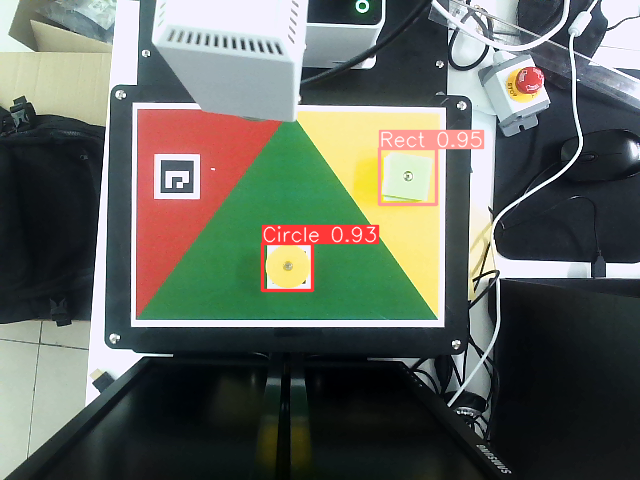

[['green', 'Rect', 408.2767333984375, 176.2318878173828], ['yellow', 'Circle', 287.877197265625, 266.7809143066406]]


In [36]:
goal_index = 1
img_rgb = get_image_from_webcam()
results = run_yolo(model, img_rgb)
result_list = get_yolo_results(results)
print(result_list)

In [37]:
# 마커 검출
detected_markers = detect_marker(image=img_rgb, marker_type="DICT_4X4_100")

# 마커 검출 이미지 보기
plt.imshow(detected_markers)
plt.show()

Detecting 'DICT_4X4_100' tags....
[Inference] ArUco marker ID: 1


In [38]:
# 아르코 마커로 카메라 좌표계 기준 6D pose 예측하기
# rvec : 회전 행렬 (roll, pitch, yaw)   // unit : rads
# tvec : 이동 행렬 (x, y, z)            // unit : meter
# corners : 아르코 마커의 각 코너 좌표  // (x, y) 픽셀 위치
rvec, tvec, corners = run_aruco(img_rgb, "DICT_4X4_100")

# 간단한 전처리
rvec = np.array(rvec)[0][0]
tvec = np.array(tvec)[0][0]
corners = np.array(corners[0][0])

print(rvec)
print("경계")
print(tvec)

ids : [[1]]
[[     2.9858   0.0032855     0.13807]]
경계
[[  -0.068159   -0.069993     0.63043]]


In [39]:
# 타겟 물체의 이동 및 회전 행렬 받아오기
goal_index = 0
goal_pose = tvec[goal_index]
goal_angle = rvec[goal_index]
print(goal_pose)
print(goal_angle)

[  -0.068159   -0.069993     0.63043]
[     2.9858   0.0032855     0.13807]


In [40]:
# 타겟 물체의 좌표 및 각도 출력 (카메라 좌표계 기준)
goal_pose[0] = np.round(goal_pose[0], 4)
goal_pose[1] = np.round(goal_pose[1], 4)
goal_pose[2] = np.round(goal_pose[2], 4)
yaw_angle_by_cam = np.round(goal_angle[-1], 4)

print(f"x based camera cordinate: {goal_pose[0]} meter")
print(f"y based camera cordinate: {goal_pose[1]} meter")
print(f"z based camera cordinate: {goal_pose[2]} meter")
print(f"yaw_angle_by_cam : {yaw_angle_by_cam} rads")

x based camera cordinate: -0.0682 meter
y based camera cordinate: -0.07 meter
z based camera cordinate: 0.6304 meter
yaw_angle_by_cam : 0.1381 rads


In [41]:
### 오차 값 보정 ##################################################################################
edit_x = -2.76    # unit : mm
edit_y = -16.28    # unit : mm
###################################################################################################

# 카메라 좌표계 -> 로봇 베이스 좌표계로 변환
point_grip = transform_cam_to_robot(goal_pose)

# 오차 보정 (로봇 베이스 좌표계 기준)
point_grip[0] = round(point_grip[0] + edit_x, 4)
point_grip[1] = round(point_grip[1] + edit_y, 4)

# 고정 값
yaw_angle_by_robot = 15
point_grip[2] = -57.5

# yaw 변환 각도 값 추가
point_grip = np.append(point_grip, yaw_angle_by_robot)
print(f"x pose by robot : {point_grip[0]} mm")
print(f"y pose by robot : {point_grip[1]} mm")
print(f"z pose by robot : {point_grip[2]} mm")
print(f"yaw angle by robot : {point_grip[3]} degree")

x pose by robot : 277.24 mm
y pose by robot : -69.28 mm
z pose by robot : -57.5 mm
yaw angle by robot : 15.0 degree


In [17]:
# 로봇 연결
dashboard, move, feed = connect_robot(ip)
dashboard.EnableRobot()
print("이제 로봇을 사용할 수 있습니다!")

# 쓰레드 설정
feed_thread = threading.Thread(target=get_feed, args=(feed,))
feed_thread.setDaemon(True)
feed_thread.start()

연결 설정 중...
연결 성공!!
Send to 192.168.1.6:29999: EnableRobot()
Receive from 192.168.1.6:29999: 0,{},EnableRobot();
이제 로봇을 사용할 수 있습니다!


/tmp/ipykernel_17649/2390342575.py:8: DeprecationWarning: setDaemon() is deprecated, set the daemon attribute instead
  feed_thread.setDaemon(True)


In [42]:
# 로봇 상태 초기화 1 : 로봇 에러 메시지 초기화
robot_clear(dashboard) 

# 로봇 상태 초기화 2 : 로봇 속도 조절
robot_speed(dashboard, speed_value)

# 로봇 현재 위치 받아오기 (x, y, z, yaw) - 로봇 베이스 좌표계 
get_Pose(dashboard)

Send to 192.168.1.6:29999: ClearError()
Receive from 192.168.1.6:29999: 0,{},ClearError();
Send to 192.168.1.6:29999: SpeedFactor(10)
Receive from 192.168.1.6:29999: 0,{},SpeedFactor(10);
Send to 192.168.1.6:29999: GetPose()
Receive from 192.168.1.6:29999: 0,{223.000015,-19.000002,100.000000,180.000000,0.000000,0.000000},GetPose();


In [43]:
# 로봇 구동 1 (초기 위치)
run_point(move, point_home)
sleep(0.1)


# 로봇 구동 3 (목표 위치)
run_point(move, point_grip)
sleep(10)
get_Pose(dashboard)

# 그리퍼 끄기
gripper_DO(dashboard, gripper_port, 1)
sleep(0.1)

# 로봇 구동 1 (초기 위치)
run_point(move, point_home)
sleep(0.1)
gripper_DO(dashboard, gripper_port, 0)

print(point_grip)

Send to 192.168.1.6:30003: MovL(223.000000,-19.000000,100.000000,180.000000)
Receive from 192.168.1.6:30003: 0,{},MovL(223.000000,-19.000000,100.000000,180.000000);
Send to 192.168.1.6:30003: MovL(277.240000,-69.280000,-57.500000,15.000000)
Receive from 192.168.1.6:30003: 0,{},MovL(277.240000,-69.280000,-57.500000,15.000000);
Send to 192.168.1.6:29999: GetPose()
Receive from 192.168.1.6:29999: 0,{277.239991,-69.279998,-57.499996,14.999999,0.000000,0.000000},GetPose();
Send to 192.168.1.6:29999: ToolDO(1,1)
Receive from 192.168.1.6:29999: 0,{},ToolDO(1,1);
Send to 192.168.1.6:30003: MovL(223.000000,-19.000000,100.000000,180.000000)
Receive from 192.168.1.6:30003: 0,{},MovL(223.000000,-19.000000,100.000000,180.000000);
Send to 192.168.1.6:29999: ToolDO(1,0)
Receive from 192.168.1.6:29999: 0,{},ToolDO(1,0);
[     277.24      -69.28       -57.5          15]


In [ ]:
def point_x_cal(x:float):
    return 2 * x - 227

def point_y_cal(y:float):
    return 2 * y - 558

In [35]:
get_Pose(dashboard)

Send to 192.168.1.6:29999: GetPose()
Receive from 192.168.1.6:29999: 0,{333.236325,-0.288884,-58.196049,182.617264,0.000000,0.000000},GetPose();


In [41]:
gripper_DO(dashboard, gripper_port, 0)

Send to 192.168.1.6:29999: ToolDO(1,0)
Receive from 192.168.1.6:29999: 0,{},ToolDO(1,0);
